In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff
import torch
import pytorch_lightning as pl

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../sympde'))

from data.dataset import PDEDataset, PDEDataModule
from data.utils import d_to_LT

from model.setup import setup_model
from model.networks.fno import FNO1d
from model.learner import Learner

from viz.plot_pde_data import plot_1ds

from run import parse_options, main

In [3]:
args = parse_options(notebook=True)
# args.pde_name = 'pde5'
# args.seed = 1
# args.version = f'{args.pde_name}_seed{args.seed}'
args.version = 'test'
args.train = False
args.num_workers = 7
args.local = True
args.batch_size = 2

In [5]:
pl.seed_everything(args.seed, workers=True)

datamodule = PDEDataModule(
    pde_name = args.pde_name, 
    data_dir = args.data_dir, 
    batch_size = args.batch_size, 
    num_workers = args.num_workers
)

model = setup_model(args)

trainer = pl.Trainer(
    logger=pl.loggers.TensorBoardLogger(
        args.log_dir, name=args.net, version=args.version
    ),
    max_epochs=args.max_epochs,
    log_every_n_steps=1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    callbacks = [
        pl.callbacks.TQDMProgressBar(refresh_rate=1000),
    ],
    deterministic=True
)  

# if args.train:
#     trainer.fit(model, datamodule=datamodule)

# trainer.test(model, datamodule=datamodule)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [6]:
datamodule.setup(stage='test')
batch = next(iter(datamodule.train_dataloader()))

In [ ]:
# set to inference mode
model.eval()


In [16]:
model = model.eval()
y_pred, y = model(batch)
y_pred = y_pred.detach().cpu().numpy()

In [99]:
y_pred.shape

torch.Size([2, 5, 256])

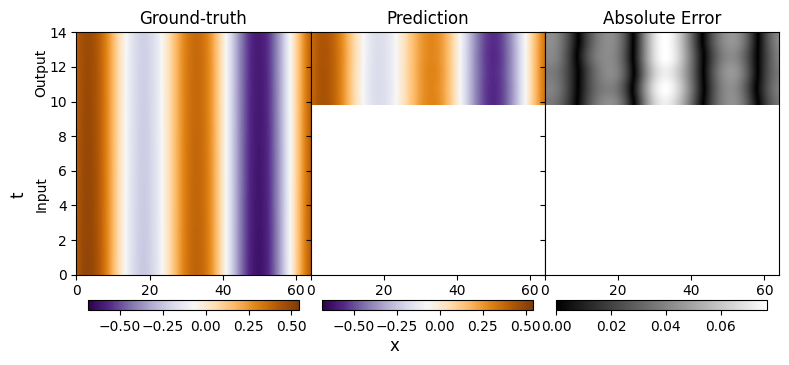

In [107]:
model.log_fig(batch, y_pred.detach())